In [60]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 

## Working with Tensorflow 
- One hidden layer
- Fashion MNIST
- Additional Code (Plot loss curve beautified)

In [61]:
# Lets import some libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

%matplotlib inline

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">
    <b>Notes:</b>
    - `EPOCHS` to 20.
    - Add `altName = 'no_frils'`
</div>

In [62]:
# Some basic parameters

inpDir = './' # location where input data is stored
outDir = './' # location to store outputs
modelDir = './'
subDir = './'

altName = 'no_frils'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 10 # number of epochs
ALPHA = 0.01 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Functions
### Plot loss curve
<div class="alert alert-block alert-warning" style="font-family: Arial; font-size:1.1em;">
    <b>Notes:</b>Following code of plotting loss curve has additional beautification.
</div>

In [63]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

### Settings so that Tensorflow can not Hog all the GPU memory

In [64]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load Fashion MNIST

In [65]:
train_df = pd.read_csv(os.path.join(inpDir, 
                                    subDir, 
                                    'fashion-mnist_train.csv'), header=0)

test_df = pd.read_csv(os.path.join(inpDir, 
                                    subDir, 
                                    'fashion-mnist_test.csv'), header=0)

In [66]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
train_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


In [68]:
#  Split the data in training and test sets to measure performance of the model.
X_train = train_df.drop('label', axis = 1).to_numpy()
X_test = test_df.drop('label', axis = 1).to_numpy()
y_train = train_df['label'].to_numpy()
y_test = test_df['label'].to_numpy()

In [69]:
X_train = X_train/255.

X_test = X_test/255.

In [70]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<div class="alert alert-block alert-warning" style="font-family: Arial; font-size:1.1em;">
    <b>Notes:</b>Added class names.
</div>

In [71]:
class_names = {0: 'T-shirt/top',
               1: 'Trouser',
               2: 'Pullover',
               3: 'Dress',
               4: 'Coat',
               5: 'Sandal', 
               6: 'Shirt',
               7: 'Sneaker', 
               8: 'Bag', 
               9: 'Ankle boot'}

## Sample data plot

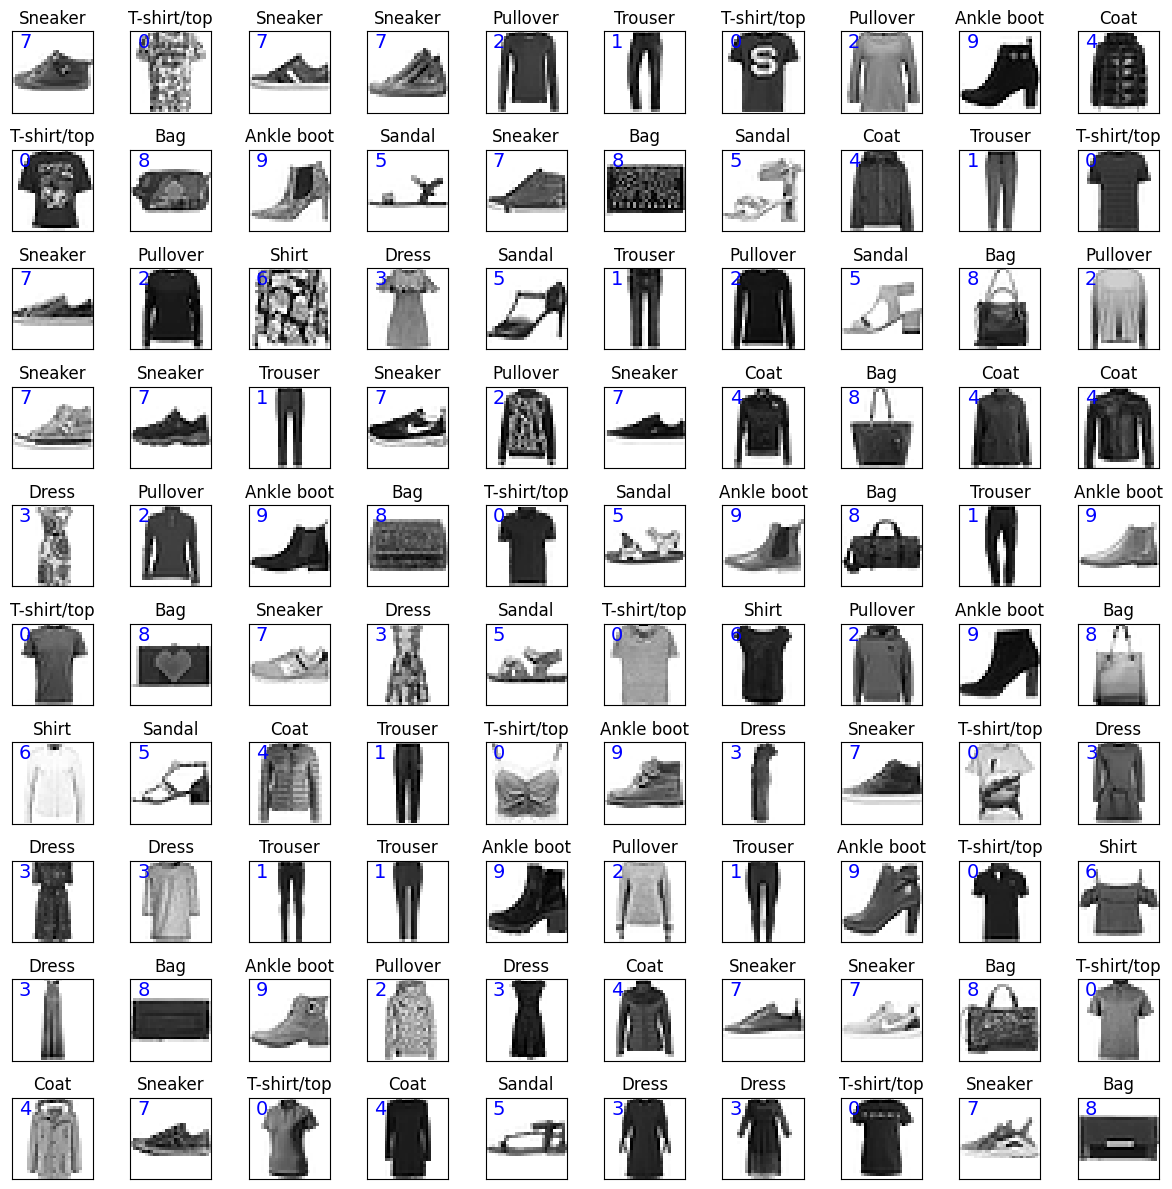

In [72]:
plot_df = train_df.sample(n=100)

fig = plt.figure(figsize=(12,12))

i = 0

for _, row in plot_df.iterrows():
    
    i += 1
    image = row.values[1:].reshape(28,28)
    ax = fig.add_subplot(10, 10, i, xticks = [], yticks = [])
    ax.imshow(image, cmap = plt.cm.binary, interpolation='nearest')
    ax.text(2, 5, str(row[0]), color='b', fontsize = 14)
    ax.set_title(class_names[row[0]], fontsize=12)
    
plt.tight_layout()
plt.show()

## Prepare model

Build the `tf.keras.Sequential` model by stacking layers from `tf.keras.layers.Dense`. Activations can be given as string or from `tf.keras.activations.tanh` 

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">
    <b>Notes:</b>Change it to `Relu`.
</div>

In [73]:
# Define Model Calling class Sequential and pass all layers as a list

model = tf.keras.Sequential([
    
    tf.keras.layers.Dense(196, activation='tanh'), # Alter : tf.keras.activations.tanh
    
    tf.keras.layers.Dense(49, activation='tanh'), # Alter : tf.keras.activations.tanh
    
    tf.keras.layers.Dense(10)
])

## Reference
<p style="font-family: Arial; font-size:1.2em;color:black;">
Details of <a href = "https://www.tensorflow.org/api_docs/python/tf/keras/Sequential">Sequential Model</a>. Sequential provides training and predict features on this model.
</p>

### Functional API

<p style="font-family: Arial; font-size:1.2em;color:black;">You can also instantiate a Model with the <strong>"Functional API"</strong>, where you start from Input, you chain layer calls to specify the model's forward pass, and finally you create your model from inputs and outputs:

>import tensorflow as tf

>inputs = tf.keras.Input(shape=(2,))
    
>x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)

>outputs = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(x)

>model = tf.keras.Model(inputs=inputs, outputs=outputs)

    
<p style="font-family: Arial; font-size:1.2em;color:black;">You can also extend the model class, if love to live by sword!!
</p>

<p style="font-family: Arial; font-size:1.2em;color:black;">
    For each example the model returns a vector of "logits" or "log-odds" scores, one for each class.
</p>

<p style="font-family: Arial; font-size:1.2em;color:black;">
    <b>Unit Test</b>: Predict using untrained model.
</p>

In [74]:
y_pred = model(X_train[:1])
y_pred

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.5753861 , -0.01317367, -0.6004138 , -0.25900638,  0.28751928,
         0.5266906 ,  0.07679921, -1.2620956 , -0.8199214 , -0.14722855]],
      dtype=float32)>

In [75]:
tf.nn.softmax(y_pred)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.06569055, 0.11525735, 0.06406687, 0.09013737, 0.155689  ,
        0.19775558, 0.12610823, 0.03305741, 0.05144019, 0.10079741]],
      dtype=float32)>

The `tf.nn.softmax` function converts these logits to "probabilities" for each class: 

In [76]:
'''
Number of parameters:
    layer 1 : 2*4 +4 = 12 
    layer 2 : 4*4 + 2 = 10
We are not locking any layer hence all parameter are trainable    
'''

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (1, 196)                  153860    
                                                                 
 dense_7 (Dense)             (1, 49)                   9653      
                                                                 
 dense_8 (Dense)             (1, 10)                   500       
                                                                 
Total params: 164013 (640.68 KB)
Trainable params: 164013 (640.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Game Changer

`Softmax` function is prone to two issues: overflow and underflow.

- <b>Overflow</b> occurs when very large numbers are being fed.
- <b>Underflow</b> occurs when very small numbers (near zero) are being fed.

There are work arounds too, but, TF has its own approach.<br>
    
Intuition being that every system (32 / 64 bit precision) has limits in terms of largest or smallest value it can accurately process.

It also leads to the vanishing gradient in exponential functions. As you go higher/lower it  will overflow and the gradient will be `zero` irrespective of actually it being a `non-zero`.

## Lose Function

Our loss function is crossentropy as there are two or more label classes. The labels are provided using one-hot representation. We will use CategoricalCrossentropy loss. 
    
>y_true = [ 0, 2 ] <b>Sparse Representation</b><br>
>y_true = [ [1      0    0], [ 0    0   1 ] <b>Dense Representation</b><br>
>y_pred = [ [0.05, 0.95, 0], [0.1, 0.1, 0.8] ]


In case, you have not one-hot-encoded use `losses.SparseCategoricalCrossentropy`. It takes a vector of logits and a `True` index and returns a scalar loss for each example.

In [77]:
import sys

sys.float_info.max

1.7976931348623157e+308

In [78]:
sys.float_info.min

2.2250738585072014e-308

In [79]:
np.log(sys.float_info.max)

709.782712893384

In [80]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy ( from_logits = True)

In [81]:
y_train[:1]

array([2], dtype=int64)

In [82]:
loss_fn(y_train[:1], y_pred).numpy()

2.747828

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">
    <b>Notes:</b>Change it to `adam` 
</div>

## Compile model
Using `model.compile`, specify the training configuration such as:
- Loss function to minimize
- Optimizer `'SGD'`
- List of metrics to monitor `'accuracy'`

In [83]:
model.compile(optimizer='SGD',
    loss=loss_fn,
    metrics=['accuracy'])

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">
    <b>Notes:</b>Add check point dir
</div>

## pass model

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">
    <b>Notes:</b>add callback `callbacks=[model_callback]''
</div>


In [84]:
history = model.fit(X_train, y_train, 
          validation_data=[X_test, y_test],
          epochs=EPOCHS
         )

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6924 - accuracy: 0.7772 - val_loss: 0.5061 - val_accuracy: 0.8255
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4741 - accuracy: 0.8326 - val_loss: 0.4499 - val_accuracy: 0.8440
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4339 - accuracy: 0.8449 - val_loss: 0.4234 - val_accuracy: 0.8519
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4106 - accuracy: 0.8543 - val_loss: 0.4065 - val_accuracy: 0.8554
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3948 - accuracy: 0.8594 - val_loss: 0.3986 - val_accuracy: 0.8589
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3809 - accuracy: 0.8643 - val_loss: 0.3837 - val_accuracy: 0.8629
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3700 - accuracy: 0.8681 - val_loss: 0.3764 - val_accuracy:

## Evaluate the model
In case we want to separately evaluate this model, we have `evaluate` function.

In [85]:
model.evaluate ( X_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.3643 - accuracy: 0.8696 - 837ms/epoch - 3ms/step


[0.3642584979534149, 0.8695999979972839]

In [86]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.692394,0.777183,0.506065,0.8255
1,0.474071,0.832583,0.449932,0.8440
2,0.433949,0.844933,0.423423,0.8519
3,0.410595,0.854300,0.406499,0.8554
4,0.394784,0.859383,0.398569,0.8589


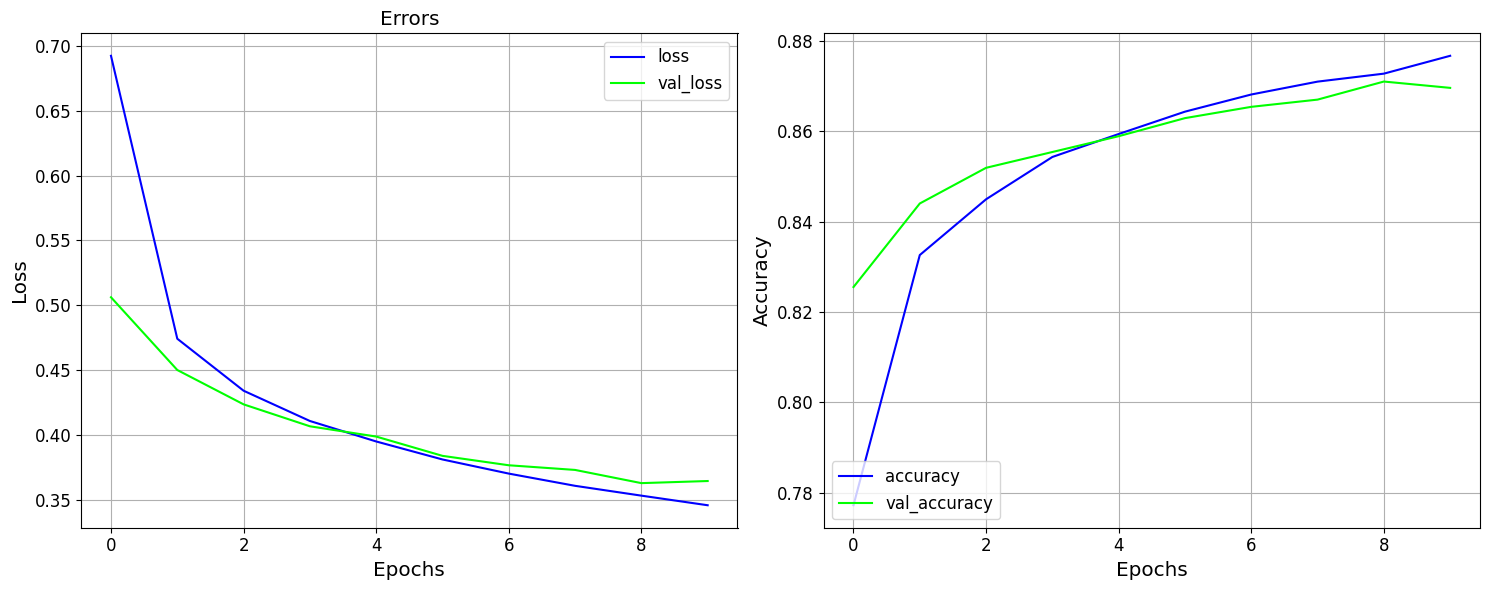

In [87]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

ax = axes[0]

hist_df.plot(y = ['loss', 'val_loss'], ax = ax, colormap=CMAP)

ax.set_xlabel("Epochs")
ax.set_ylabel('Loss')
ax.set_title('Errors')
ax.grid();
ax = axes[1]

hist_df.plot( y = ['accuracy', 'val_accuracy'], ax = ax, colormap=CMAP)

ax.set_xlabel("Epochs")
ax.set_ylabel('Accuracy')
ax.grid()
ax.legend(loc = 'lower left')

plt.tight_layout()

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">
    <b>Notes:</b>demonstrate function call
</div>

## Predictions
Build a prediction model using `tf.keras.Sequential` again and add `tf.keras.layers.Softmax` to model.

Make predictions and print classification reports and confusion matrix.

In [88]:
prob_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

In [89]:
y_pred = prob_model(X_train)

In [90]:
print(classification_report(y_train, np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      6000
           1       0.99      0.96      0.97      6000
           2       0.84      0.75      0.79      6000
           3       0.82      0.93      0.87      6000
           4       0.77      0.84      0.80      6000
           5       0.97      0.94      0.95      6000
           6       0.71      0.70      0.71      6000
           7       0.93      0.94      0.94      6000
           8       0.96      0.97      0.96      6000
           9       0.95      0.96      0.96      6000

    accuracy                           0.88     60000
   macro avg       0.88      0.88      0.88     60000
weighted avg       0.88      0.88      0.88     60000



In [91]:
y_pred = prob_model(X_test).numpy()

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(y_test, 
                                                                  np.argmax(y_pred, axis = 1))))

Accuracy score on Test Data :0.86960


In [92]:
print(classification_report(y_test, 
                            np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1000
           1       0.98      0.97      0.97      1000
           2       0.85      0.72      0.78      1000
           3       0.84      0.93      0.88      1000
           4       0.78      0.86      0.82      1000
           5       0.95      0.91      0.93      1000
           6       0.67      0.68      0.68      1000
           7       0.91      0.92      0.91      1000
           8       0.95      0.96      0.96      1000
           9       0.93      0.95      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



<div class="alert alert-block alert-warning" style="font-family: Arial; font-size:1.1em;">
    <b>Notes:</b>Added Display labels
</div>

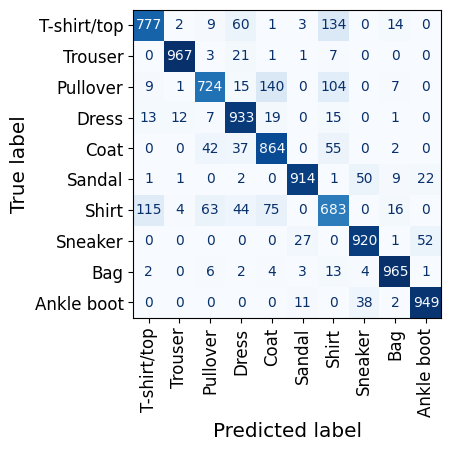

In [93]:
cm  = confusion_matrix(y_test, np.argmax(y_pred, axis = 1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">
    <b>Notes:</b>add function to plot results data
</div>